In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
from tensorflow.examples.tutorials.mnist import input_data

## I. CONVOLUTION

### A. EDGE DETECTION

Before Gray Transformation



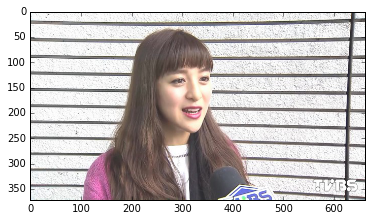


After Gray Transformation



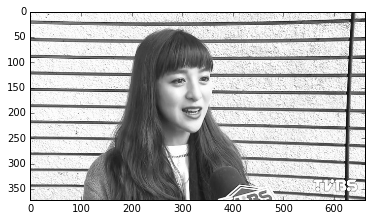

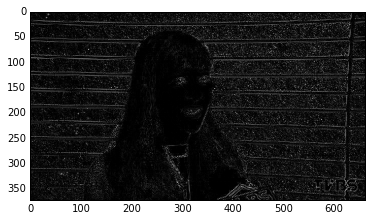

In [42]:
# GRAYSCALE CONVERSION

image = mpimg.imread("/Users/jacobsw/Desktop/CODER/TENSORFLOW/FIGS/kelly.jpg")
print 'Before Gray Transformation\n'
plt.imshow(image)
plt.show()
print
image = np.dot(image, [0.299, 0.587, 0.114]) # https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale.
implot = plt.imshow(image)
implot.set_cmap('gray')
print 'After Gray Transformation\n'
plt.show(implot)
print

# EDGE DETECTING KERNEL (3 x 3)
# NB: a 'kernel' is a filter, while a 'feature map' is a resulted new matrix after filtering.

kernel = np.array([[0, 1, 0],
                   [1,-4, 1],
                   [0, 1, 0]])
grad = signal.convolve2d(image, kernel, mode='same', boundary='symm')
plt.imshow(np.absolute(grad), cmap='gray')
plt.show()

In [ ]:
# ALTERNATIVE IMAGE IMPORT METHOD

# import urllib, cStringIO
# url = "http://cc.tvbs.com.tw/news3.0/tvbs/news/entertainment/images/2016/02/27/TVBS-N_CLEAN_10M_20160227_19-20-05.mp4_20160227_193703.914.jpg"
# f = cStringIO.StringIO(urllib.urlopen(url).read())
# img = Image.open(f)
# im = np.asarray(img)

### B1. MNIST CLASSIFCATION (BASELINE)

In [58]:
# LOAD DATA

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print

# BUILD GRAPH

x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])
W = tf.Variable(tf.zeros([784,10], tf.float32))
b = tf.Variable(tf.zeros([10], tf.float32))
y_pred = tf.nn.softmax(tf.add(tf.matmul(x, W), b))

correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_pred), reduction_indices=[1])) # cross entropy.

# CONFIG MODEL

train = tf.train.GradientDescentOptimizer(.5).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# TRAINING

for i in range(1000):
    batch = mnist.train.next_batch(50)
    _, cur_loss, cur_acc = sess.run([train, loss, accuracy], feed_dict={x:batch[0], y:batch[1]})
    if i % 100 == 0:
        print 'Current Train Stats: (loss=%.f, acc=%.f%%)' % (cur_loss, cur_acc*100)
print
        
# EVALUATION

acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels}) * 100
print "Test Accuracy: %.f%%" % acc

sess.close()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Current Train Stats: (loss=2, acc=10%)
Current Train Stats: (loss=0, acc=84%)
Current Train Stats: (loss=0, acc=96%)
Current Train Stats: (loss=0, acc=86%)
Current Train Stats: (loss=0, acc=96%)
Current Train Stats: (loss=0, acc=82%)
Current Train Stats: (loss=0, acc=98%)
Current Train Stats: (loss=0, acc=94%)
Current Train Stats: (loss=1, acc=86%)
Current Train Stats: (loss=0, acc=94%)

Test Accuracy: 91%


### B2: MNIST CLASSIFICATION (CONV NET)

In [71]:
# HELPER FUNCS

def initialize_variable(shape, vtype):
    return tf.Variable(tf.truncated_normal(shape, stddev=.1)) if vtype=='weight' else \
           tf.constant(.1, shape=shape) # shape: [height, width, input/channel, output/feature_map].
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        # ksize: kernel size, [num_in_batch, height, width, num_channel].
        # dimensions same for strides.

# BUILD GRAPH

x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])
x_image = tf.reshape(x, [-1, 28, 28, 1])

W_conv1 = initialize_variable([5,5,1,32], vtype='weight') # 5 x 5 filter, channel=1 (grayscale), 32 feature maps.
b_conv1 = initialize_variable([32], vtype='bias')
h_conv1 = tf.nn.relu(tf.add(conv2d(x_image, W_conv1), b_conv1))
h_pool1 = max_pool_2x2(h_conv1)
layer1 = h_pool1 # image: 28 x 28 -> 14 x 14 by maxpooling; feature maps: 1 -> 32 by convolution.

W_conv2 = initialize_variable([5,5,32,64], vtype='weight')
b_conv2 = initialize_variable([64], vtype='bias')
h_conv2 = tf.nn.relu(tf.add(conv2d(layer1, W_conv2), b_conv2))
h_pool2 = max_pool_2x2(h_conv2)
layer2 = h_pool2 # image: 14 x 14 -> 7 x 7 by maxpooling; feature maps: 32 -> 64 by convolution.
layer2_mat = tf.reshape(layer2, [-1, 7*7*64]) # flatten, but ignore num_in_batch with -1.

W_dense1 = initialize_variable([7*7*64, 1024], vtype='weight')
b_dense1 = initialize_variable([1024], vtype='bias')
h_dense1 = tf.nn.relu(tf.add(tf.matmul(layer2_mat, W_dense1), b_dense1))
layer3 = h_dense1 # flattened image: 7*7*64=3136 -> 1024.
keep_prob = tf.placeholder(tf.float32)
layer3_drop = tf.nn.dropout(layer3, keep_prob) # dropout at a prob.

W_dense2 = initialize_variable([1024, 10], vtype='weight')
b_dense2 = initialize_variable([10], vtype='bias')
y_pred = tf.nn.softmax(tf.add(tf.matmul(layer3_drop, W_dense2), b_dense2)) # 1024 -> 10 for 10-class prediction.

loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=[1]))

correct = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# CONFIG MODEL

train = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# TRAINING

for i in range(1000):
    batch = mnist.train.next_batch(50)
    _, cur_loss, cur_acc = sess.run([train, loss, accuracy], feed_dict={x:batch[0], y:batch[1], keep_prob:.5})
    if i % 100 == 0:
        print 'Current Train Stats: (loss=%.f, acc=%.f%%)' % (cur_loss, cur_acc*100)
print

# EVALUATION

acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels, keep_prob:1.0}) * 100
print "Test Accuracy: %.f%%" % acc

sess.close()

Current Train Stats: (loss=10, acc=12%)
Current Train Stats: (loss=1, acc=66%)
Current Train Stats: (loss=1, acc=82%)
Current Train Stats: (loss=0, acc=80%)
Current Train Stats: (loss=0, acc=88%)
Current Train Stats: (loss=0, acc=100%)
Current Train Stats: (loss=0, acc=96%)
Current Train Stats: (loss=0, acc=96%)
Current Train Stats: (loss=0, acc=92%)
Current Train Stats: (loss=0, acc=98%)

Test Accuracy: 97%


## II. DIVE INTO LAYERS

COMPARE 'SAME' & 'VALID' FILTERING



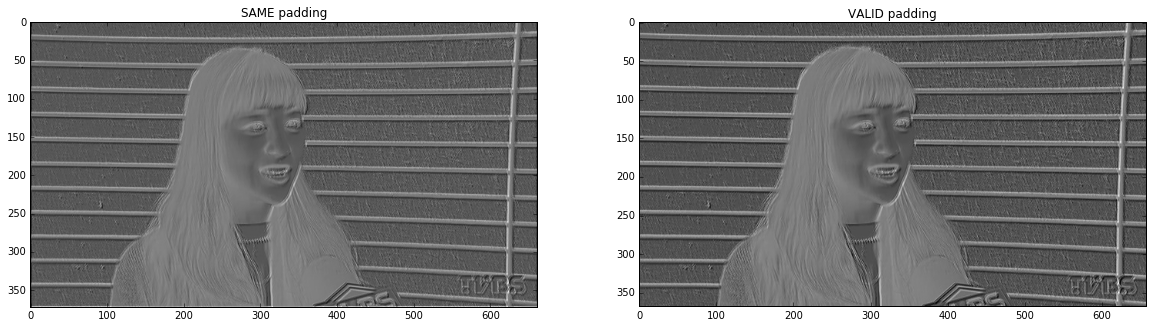


INVESTIGATE FEATURE MAPS



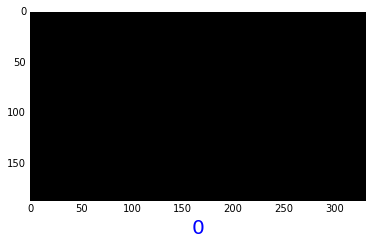

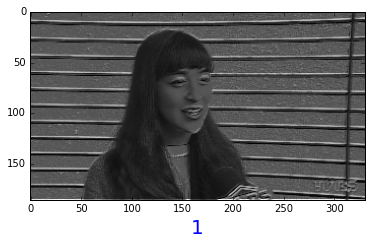

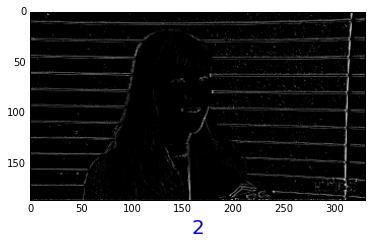

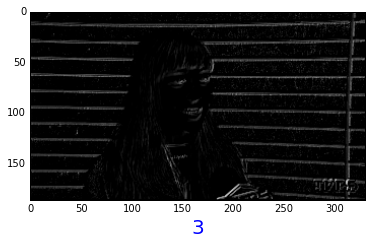

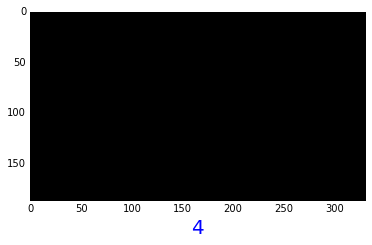

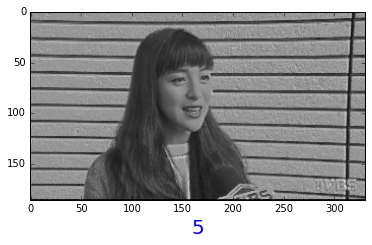

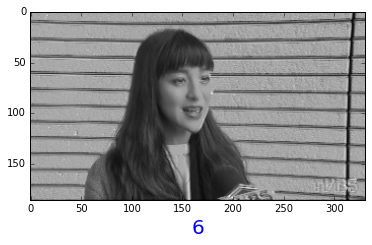

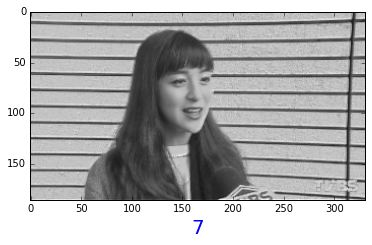

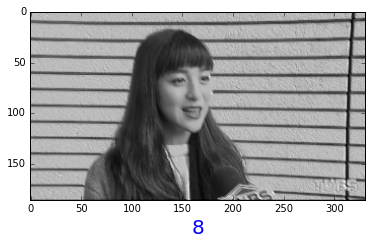

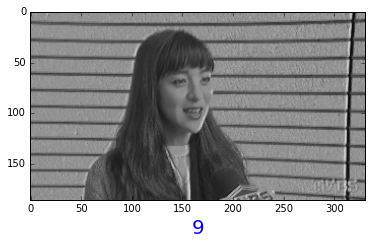

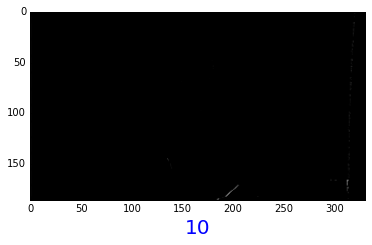

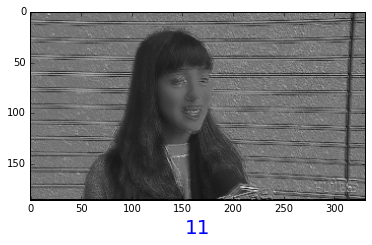

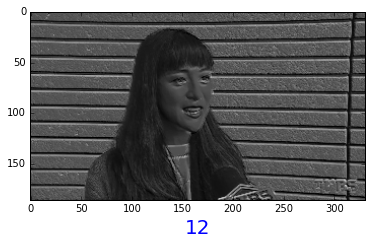

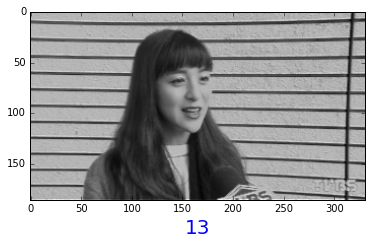

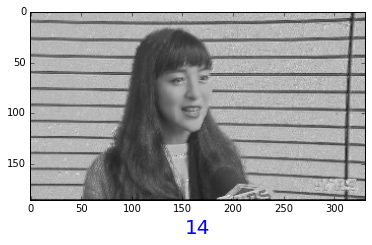

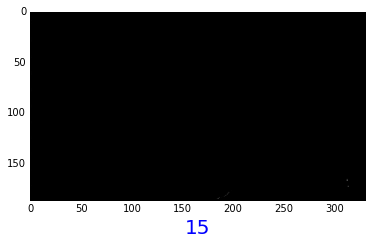

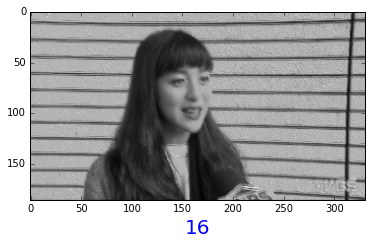

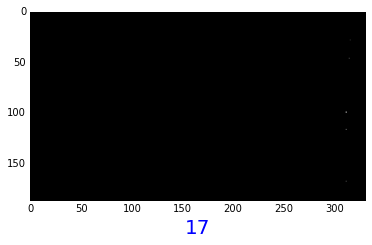

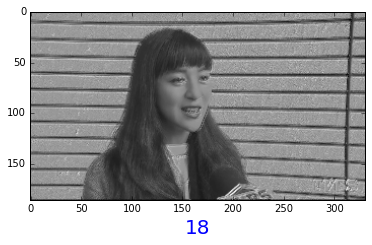

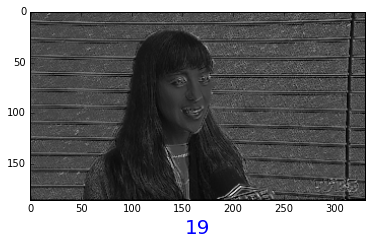

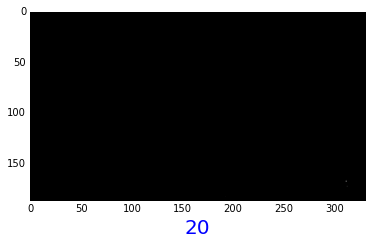

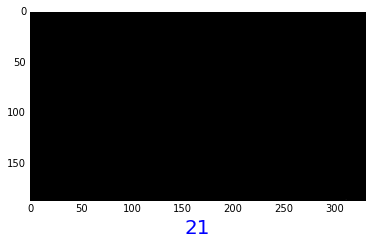

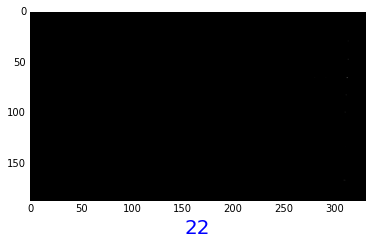

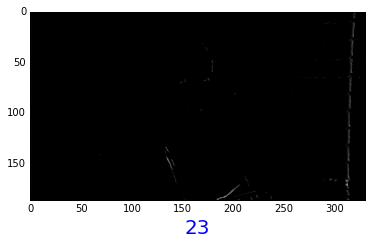

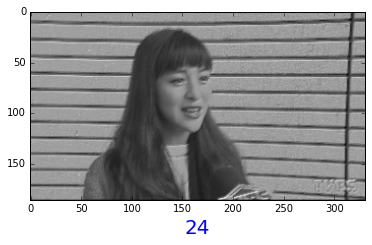

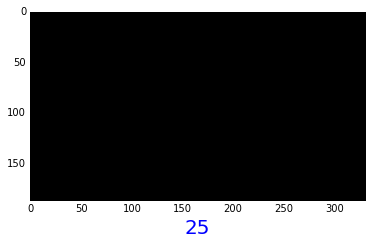

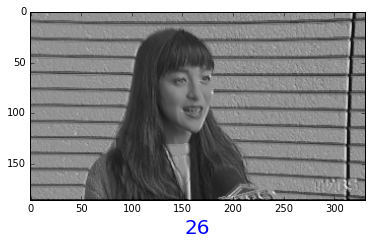

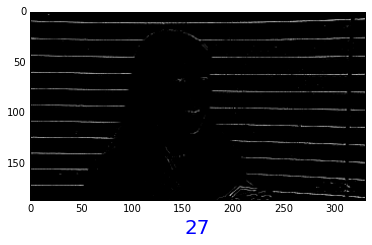

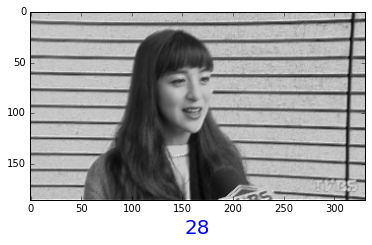

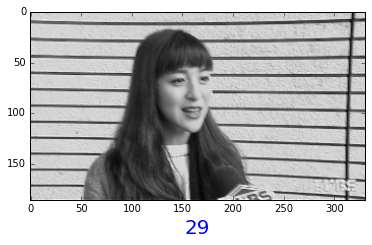

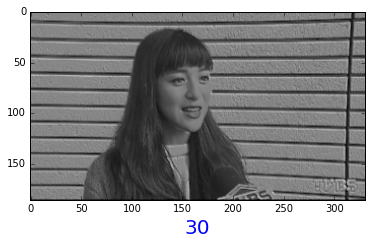

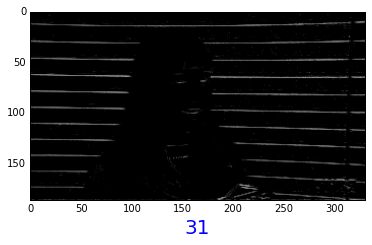

In [89]:
# LOAD IMAGE

image = np.expand_dims(np.expand_dims(np.dot(mpimg.imread("/Users/jacobsw/Desktop/CODER/TENSORFLOW/FIGS/kelly.jpg"), 
                                      [0.299, 0.587, 0.114]), 0), -1)
    # operations: load -> to gray -> expand at first dimension -> expand at last dimension.
    # results in standard format: [num_in_batch, height, width, channel].

# TEST 1: COMPARE 'SAME' AND 'VALID' FILTERING

print "COMPARE 'SAME' & 'VALID' FILTERING\n"

img = tf.placeholder(tf.float32, shape=image.shape)
weights = tf.Variable(tf.truncated_normal([5,5,1,1], stddev=.05))
conv1 = tf.nn.conv2d(img, weights, strides=[1,1,1,1], padding='SAME')
conv2 = tf.nn.conv2d(img, weights, strides=[1,1,1,1], padding='VALID')

sess = tf.Session()
sess.run(tf.global_variables_initializer())

result1 = sess.run(conv1, feed_dict={img:image})
result2 = sess.run(conv2, feed_dict={img:image}); 
vec1 = np.reshape(result1, (1,-1)) # first_dim=1, second=unspecified (i.e., flatten).
vec2 = np.reshape(result2, (1,-1)) 
image1 = np.reshape(vec1, (372, 662))
image2 = np.reshape(vec2, (368, 658))

plt.subplots(figsize=(20, 6))
plt.subplot(121); plt.imshow(image1,cmap='gray'); plt.title('SAME padding')
plt.subplot(122); plt.imshow(image2,cmap='gray'); plt.title('VALID padding')
plt.show()

sess.close()
print

# TEST 2: WHAT'S IN DIFFERENT FEATURE MAPS?

print "INVESTIGATE FEATURE MAPS\n"

weights = tf.Variable(tf.random_normal([5,5,1,32]))
biases = tf.Variable(tf.random_normal([32]))
conv = tf.nn.relu(tf.add(tf.nn.conv2d(img, weights, strides=[1,1,1,1], padding='SAME'), biases))
max_pool = tf.nn.max_pool(conv, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

sess = tf.Session()
sess.run(tf.global_variables_initializer())

out = sess.run(max_pool, feed_dict={img:image})
vec = np.reshape(out, (186,331,32))
for i in range(32):
    cur_ftmap = vec[:,:,i]
    plt.imshow(cur_ftmap, cmap='gray')
    plt.xlabel(i, fontsize=20, color='blue')
    plt.show()
    plt.close()

sess.close()